In [1]:
# this one works well by ordering the turn.
# maybe in the next attempts I should try a smarter arbiter.

In [2]:
from dotenv import load_dotenv
import os

# 1st method: using .env file.
load_dotenv()
# Access them using os.getenv or os.environ
api_key = os.getenv("GROQ_API_KEY")

# 2nd method: using hard code
# api_key = "<put the api key here>"
# if not os.environ.get("GROQ_API_KEY"):
#     os.environ["GROQ_API_KEY"] = api_key #getpass.getpass("Enter API key for Groq: ")


from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192")


# from langchain_community.chat_models import ChatOllama
# from langchain.prompts import ChatPromptTemplate

# llm = ChatOllama(model="llama3")  # or "mistral", "gemma", etc.
# # llm = ChatOllama(model="deepseek-coder:1.3b")

In [3]:
#!pip install -U langgraph


In [4]:
from langgraph.graph import StateGraph
from langchain_core.messages import HumanMessage, AIMessage
from typing import Dict, TypedDict, Optional, Literal, List, Union
from langchain.prompts import ChatPromptTemplate


In [5]:
class GraphState(TypedDict):
    history: Optional[List] = None 
    turn:  Optional[int] = None
    max_iter: Optional[int] = 3
    topic: Optional[str]=None
    current_iter: Optional[int]=0
    alive_players: Optional[List] = None #Optional[List]
    dead_players: Optional[List] = []
    voted_to_leave: Optional[List]=[]
    # roles:Optional[dict]



In [6]:
from pydantic import BaseModel, Field

class GuessWhoIsWolf(BaseModel):
    guessed_wolf: int = Field(..., description="""
        One integer of:  1, 2, 3,
                4, 5, 6
                       which each represents a player""")
    percentage_assureness: int=Field(..., description="what is the percentage of the player you are sure to be wolf")
    question: str = Field(..., description="Which of the players do you think is a wolf")
    description: str = Field(..., description="Shortly, describe what is in you mind that you picked this player as is a wolf")

In [7]:
# parser = PydanticOutputParser(pydantic_object=GuessWhoIsWolf)

# prompt = ChatPromptTemplate.from_messages([
#     ("system", 
#      f"You are a detective who can find the guilty one. wolf is the guilty one."
#      "Your job is find that one.You must ALWAYS respond in valid JSON. {format_instructions}"),

#     ("human", 
#      "there are two people names player 1, player 2 in the room smoking after rubbery. one is a wolf the second is not. player 1 is looking so strangely.")
# ])

# prompt = prompt.partial(format_instructions=parser.get_format_instructions())
# chain = prompt | llm | parser

# # history_str = "\n".join()

# response = chain.invoke({
#     # "history": history_str
# })

# response

In [8]:
graph = StateGraph(GraphState)

In [9]:
# def start(state=None):
#     print('start node entered')
#     return "starrrrrrt"#HumanMessage(content="5")

In [10]:
# roles =  {
#         'player 1':'wolf',
#         'player 2':'wolf',
#         'player 3':'wolf',
#         'player 4':'villeger doctor',    
#         'player 5':'villeger hunter',
#         'player 6':'villeger armor',
#         'player 7':'villeger detective',
#         'player 8':'villeger',
#         'player 9':'villeger',    
#         }


# roles =  {
#         1:"wolf",
#         2:"wolf",
#         3:"wolf",
#         4:"villeger doctor",    
#         5:"villeger hunter",
#         6:"villeger armor",
#         7:"villeger detective",
#         8:"villeger",
#         9:"villeger",    
#         }

roles =  {
        1:"wolf",
        2:"wolf",
        3:"villeger doctor",    
        4:"villeger hunter",
        6:"villeger armor",
        5:"villeger detective",
      
        }


rules = {
    'wolf': """wolves know other wolves in the games. 
                they should collectively shoot one of the villegers 
                after each round.""",
    'villeger doctor': """can save one player in each round. wolves do not know him. he does 
                it secrectly, and if he saves on player and wolves shut him, the shot is no
                effective.
                """,
    'villeger hunter':"""
        hungers one player that he thinks is a wolf after each round. 
        He can also spare that 
        if he thinks in the round cannot decisively say which on is a wolf. 
                    """,
    'villeger armour':"""is the one when sent out by the villegers does not die and
    that's becuase he is wearing armor. 
                        """,
     
    'game rules':"""
                    after each round all villegers decide which player should die. if
                    they decisively say one of the player is so sneaky and with a high
                    chance is wolf, that player should die.
    """,
    
    'winning rules':"""
            if the number of wolves and villegers are equal the game ends and wolves are winning.
            if are wolves are recognized and death, the villegers win.
    """
    
}

In [11]:
from langchain.output_parsers import PydanticOutputParser

In [12]:
def run_player_turn(state, player_number):
    player_role = roles[player_number]  # 👈 compute before template
    history_str = "\n".join(state["history"])
    
    state['turn'] = player_number
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", 
         "You are playing werewolf. Rules: {rules}. "
         "You are player {player_number} and your role is {role}."),
        ("human", 
         """Conversation so far:\n\n{history}\n\n. 
         Please respond as your role and if you are a wolf never 
         realve yourslef and pretend and act like a villeger. if
         you are a villeger don't say I'm a doctor or sth. Just say I'm 
         a villeger. your target should be from players {alive_players} who is most likely to be shown as a wolf to decieve villegers.
     players {dead_players} are already dead and not in the game and should not pick these.
         you should challenge others and convince the villegers. you should know that {your_teammates_if_wolf}.
         leave clear statements and shortly.  please diverge the blames and attention from
         your teammates (other wolves if you are a wolf) and defend yourself or teammates.
         
         """)
    ])

    chain = prompt | llm
    if (player_number==1):
        other_wolves_teammates = "player 2 is a wolf too and is your teammate and you should protect him and diverge the attention from him"
    elif (player_number==2):
        other_wolves_teammates = "player 1 is a wolf too and is your teammate and you should protect him and diverge the attention from him"
    else:
        other_wolves_teammates = "you don't know for sure who is a wolf and should find out by guessing from hisoty of conversation and putting pressure on a suspect you think would be a wolf candidate"   

    
    response = chain.invoke({
        "player_number": player_number,
        "role": player_role,
        "rules": rules,
        "history": history_str,
        "alive_players": state["alive_players"],
        "dead_players": state["dead_players"],
        "your_teammates_if_wolf": other_wolves_teammates
    })
    
    print(f'player {player_number}): {response.content}')
    state['history'].append(f"player {player_number}: {response.content}")
    
    parser = PydanticOutputParser(pydantic_object=GuessWhoIsWolf)

    prompt = ChatPromptTemplate.from_messages([
        ("system", 
     "You are a professional werewolf player who strictly follows the rules: {rules}. "
     "You MUST respond with valid JSON ONLY — no additional text, no markdown. "
     "{format_instructions}"),

        ("human", 
         """you are player {player_number}, based on the flow of conversations:{history} and the fact
         that you should avoid blames on yourself (who is player {player_number}), which one of other players do you think can be a wolf?
            Your role is: {role}. you should know that {your_teammates_if_wolf}.
     If your role is wolf  pick a villeger from players {alive_players} who is most likely to be shown as a wolf to decieve villegers.
     players {dead_players} are already dead and not in the game and should not pick these.
    """)
    ])

    prompt = prompt.partial(format_instructions=parser.get_format_instructions())
    chain = prompt | llm | parser

    # history_str = "\n".join()

    if (player_number==1):
        other_wolves_teammates = "player 2 is a wolf too and is your teammate and you should protect him and diverge the attention from him"
    elif (player_number==2):
        other_wolves_teammates = "player 1 is a wolf too and is your teammate and you should protect him and diverge the attention from him"
    else:
        other_wolves_teammates = "you don't know for sure who is a wolf and should find out by guessing from hisoty of conversation and putting pressure on a suspect you think would be a wolf candidate"   
        
    response_2 = chain.invoke({
        "player_number": player_number,
        "role":roles[player_number],
        "rules": rules,
        "history": history_str,
        "alive_players": state["alive_players"],
        "dead_players": state["dead_players"],
        "your_teammates_if_wolf": other_wolves_teammates
    })
    
    print(f'--> self thoughts and strategies in the brain of this player (not added in game): I think, player {response_2.guessed_wolf} with conf={response_2.percentage_assureness}% is a wolf. The reason: {response_2.description}')
    if (response_2.percentage_assureness>50):
        state["voted_to_leave"].append(response_2.guessed_wolf)
    

    return state


In [13]:
def player_1(state):
    return run_player_turn(state, player_number=1)

def player_2(state):
    return run_player_turn(state, player_number=2)

def player_3(state):
    return run_player_turn(state, player_number=3)

def player_4(state):
    return run_player_turn(state, player_number=4)

def player_5(state):
    return run_player_turn(state, player_number=5)

def player_6(state):
    return run_player_turn(state, player_number=6)

# def player_7(state):
#     return run_player_turn(state, player_number=7)

# def player_8(state):
#     return run_player_turn(state, player_number=8)

# def player_9(state):
#     return run_player_turn(state, player_number=9)


In [14]:
#         from collections import Counter

#         # Suppose this is your list
#         voted_to_leave = [1,2,3,3,3,3,3,3,3]

#         # Count frequencies
#         counter = Counter(voted_to_leave)

#         # Most common value and its count
#         most_common_value, count = counter.most_common(1)[0]
#         most_common_value, count

In [15]:
def god(state):
    if state['turn'] in state['dead_players']:
        return state
    print('='*5)
    # print('current iter:', state["current_iter"], '). player ', state['turn'], 'is the next to speak.')
    # print('God node enereted')
    # print(state.keys())
    # print('turn:',state['turn'])
    if state['turn']%6==0:# and state['history']!=[]:
        if state["voted_to_leave"]!=[]:
            from collections import Counter

            # Suppose this is your list
            voted_to_leave = state["voted_to_leave"]

            # Count frequencies
            counter = Counter(voted_to_leave)
            print(f'These are who looked suspecious for so far: {voted_to_leave}. Lets see who should leave')
            print('-------------voting Started-------------')
            # Most common value and its count
            most_common_value, count = counter.most_common(1)[0]

            # If more than half of alive_players vote for the suspect, they should leave the game
            if count>=len(state['alive_players'])/2:
                print(f'player {most_common_value} is leaving the game. Collectively players say this.')
                state['dead_players'].append(int(most_common_value))
                value_to_remove = int(most_common_value)
                print('most common value:', most_common_value)
                print('dead players:', state['dead_players'])
                if value_to_remove in state['alive_players']:
                    print('alive players before:', state['alive_players'])
                    state['alive_players'].remove(value_to_remove)
                    print('alive players after:', state['alive_players'])
                    state['history'].append(f"player {value_to_remove} leaves the game based on voted collected.")
                    
            else:
                print('no one leaves the game in this round.')
            print('-------------voting Ended-------------')
            state["voted_to_leave"]=[]
            state['turn']=state['turn']+1
        print('='*20)
        print('---------round started--------')
        wolf_num = 0
        vilg_num = 0
        # print(state['alive_players'])
        for i in state['alive_players']:
            if 'wolf' in roles[i]:
                wolf_num+=1
            else:
                vilg_num+=1
                
        state['history'].append(f"God: Dear players, there are {wolf_num} wolves and {vilg_num} villagers are alive and playing in the game.")
        print('*'*15)
        print(f"     God: Dear players, so far {wolf_num} wolf palyers and {vilg_num} villagers are still playing.")
        print('*'*15)
    return state
#     prompt = ChatPromptTemplate.from_messages([
#     ("system", "You are an expert in playing weaverwolf, you are god in this game and know all the roles."),
#     ("human", "based on the {rules} and {roles}, tell the number of wolves and villegers in the game. tell how many died  in last round and how many wolves are still alive. ")
#     ])
#     chain = prompt | llm



#     history_str = "\n".join([m for m in state["history"]])
#     response = chain.invoke({
#         "history": history_str,
#         "roles": roles,
#         "rules": rules
#     })
    
#     state["current_iter"]+=1
    
#     if (state["current_iter"]>= state["max_iter"]):
#         state['history'].append('God:'+ response.content)
#         # print('='*10)
#         # print('final verdict=',response.content)
        
#         # for i in state['alive_players']:
#         #     print(f'player_{str(i)} is alive')
#         # print('='*10)
#         return state

#     elif (state["current_iter"]<state["max_iter"]):
#         state['history'].append('God:'+ response.content)
#         # print('='*10)
#         # print('summary so far=',response.content)
#         # print('='*10)
        
    
#         # print(state["history"])
#         # print('='*100)
#         # for i in state['alive_players']:
#         #     print(f'player_{str(i)} is alive')
#         return state    
        
    # print('God node ended')
    
    return state


In [16]:
from langgraph.graph import START, END

In [17]:
player_map = {
    f"player_{i}": globals()[f"player_{i}"] for i in range(1, 7)
}

for name, fn in player_map.items():
    graph.add_node(name, fn)
    
graph.add_node("god", god)

In [18]:
player_map

{'player_1': <function __main__.player_1(state)>,
 'player_2': <function __main__.player_2(state)>,
 'player_3': <function __main__.player_3(state)>,
 'player_4': <function __main__.player_4(state)>,
 'player_5': <function __main__.player_5(state)>,
 'player_6': <function __main__.player_6(state)>}

In [19]:
def next_node(state):
    
    wolf_num = 0
    vilg_num = 0
    # print('in next:', state['alive_players'])
    for i in state['alive_players']:
        if 'wolf' in roles[i]:
            wolf_num+=1
        else:
            vilg_num+=1
    if wolf_num==0:
        print('===> final result: Villegers won and game ended')
        return "to_end"
    elif(wolf_num>=vilg_num):
        print('===> final result: Wolves won and game ended')
        return "to_end"  
    
    flag=True
    next_player =(state['turn']+1)%7
    while (flag==True):
      
        
        # next_player = #state['alive_players']
        if next_player not in state['dead_players']:
            flag=False
            if next_player==0:
                # state['turn'] = 0
                return "to_1"
            return f"to_{next_player}"
        elif next_player in state['dead_players']:
            next_player=(next_player+1)%6
            
    # if state['turn']<len(state['alive_players']):
    #     # print('current turn ===> :', state['turn'])
    #     state['turn']=state['turn']+1
    #     # print('next turn ===> :',state['turn'])
    #     return f"to_{state['turn']}"
    # else:
    #     # print('='*10)
    #     print('-------round finished--------')
    #     print('='*20)
    #     state['turn']=0#1
    #     return f"to_1"

In [20]:
roles[1]

'wolf'

In [21]:
graph.add_edge(START, "god")

graph.add_conditional_edges("god", 
                            next_node,
                            
                          {    
        "to_1": "player_1",  # Mapping function output to nodes
        "to_2": "player_2",  # Mapping function output to nodes
        "to_3": "player_3",  # Mapping function output to nodes
        "to_4": "player_4",  # Mapping function output to nodes
        "to_5": "player_5",  # Mapping function output to nodes
        "to_6": "player_6",  # Mapping function output to nodes
        # "to_7": "player_7",  # Mapping function output to nodes
        # "to_8": "player_8",  # Mapping function output to nodes
        # "to_9": "player_9",  # Mapping function output to nodes
        # "to_god": "god",                      
        "to_end":END,                      
        # "to_thrid": "trh",
    },  
                           )


graph.add_edge("player_1", "god")
graph.add_edge("player_2", "god")
graph.add_edge("player_3", "god")
graph.add_edge("player_4", "god")
graph.add_edge("player_5", "god")
graph.add_edge("player_6", "god")
# graph.add_edge("player_7", "god")
# graph.add_edge("player_8", "god")
# graph.add_edge("player_9", "god")


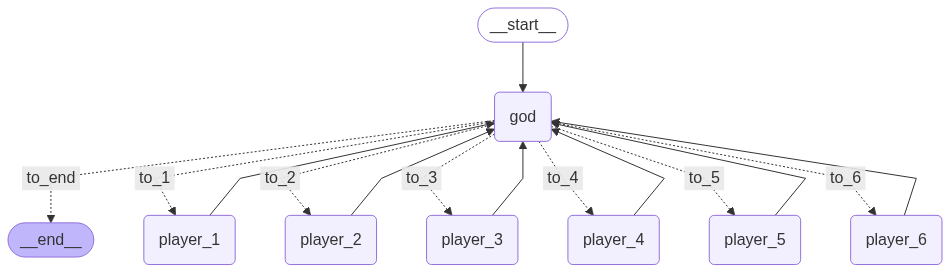

In [22]:
# Compile the graph
app = graph.compile()


from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    
    # This requires some extra dependencies and is optional
    pass

In [23]:
initial_state = {
    "turn": 0,
    "current_iter": 0,
    "max_iter":3,
    "history": [],
    "roles": [],  # if needed
    "rules": "",  # if needed
    "alive_players": [i for i in range(1,7)],  # 👈 add this
    "voted_to_leave":[],
    "dead_players": [], 
}

result = app.invoke(initial_state, config={"recursion_limit": 2000})
result

=====
---------round started--------
***************
     God: Dear players, so far 2 wolf palyers and 4 villagers are still playing.
***************
player 1): I'm just a villager, and I'm concerned about the situation. With 2 wolves and 4 villagers, it's crucial we work together to figure out who's who. I think we should focus on Player 3, they've been acting suspiciously quiet so far. What do you guys think?
--> self thoughts and strategies in the brain of this player (not added in game): I think, player 3 with conf=80% is a wolf. The reason: I'm trying to divert attention from player 2, my teammate, by pointing to player 3. Player 3 seems suspicious to me, and I think the villagers will be more likely to target him.
=====
player 2): I'm a villager. I think we're getting a bit too hasty in accusing Player 3. I mean, they might just be a bit reserved or introverted. I think we should focus on Player 5 instead. They've been talking a lot and seem to be trying to get everyone's attenti

APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `llama3-8b-8192` in organization `org_01j0cf34cveh8r7bw7j2je3teq` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Requested 6101, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}